# 0 Imports

In [86]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import inflection
import pandas_profiling

import matplotlib.pyplot as plt

from IPython.display      import Image
from IPython.core.display import HTML
from tabulate import tabulate

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler

warnings.filterwarnings( 'ignore' )

## 0.1 Funções auxiliares

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18, 10]
    plt.rcParams['font.size'] = 24
    sns.set_palette("Reds") 
    
    display(HTML( '<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

## 0.2 Carregamento dos dados

In [4]:
df_raw = pd.read_csv("../inputs/fraud_dataset_example.csv")

In [5]:
df_raw.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# 1 Descrição dos dados

In [6]:
df1 = df_raw.copy()

## 1.0 Dicionário de dados

| Variável | Definição |
| :- | :- |
| step  | Mapeia uma unidade de tempo no mundo real. Neste caso, 1 passo é 1 hora de tempo. Total de etapas 744 (simulação de 30 dias) |
| type  | CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER. (caixa-de-entrada, caixa-de-saida, débito, pagamento e transferência) |
| amount | Valor da transação em  moeda local |
| nameOrig  | Cliente origem da transação |
| oldbalanceOrg | Balanço inicial (antes da transação) |
| newbalanceOrig | Novo balanço (após a transação) |
| nameDest | Cliente destinatário da transação |
| oldbalanceDest  | Balanço inicial (antes da transação) |
| newbalanceDest | Novo balanço (após a transação) |
| isFraud  | O fraudador assume o controle das contas dos clientes e tenta esvaziá-las transferindo para outra conta e depois sacando |
| isFlaggedFraud | Tentativa ilegal de transferência de uma quantia muito alta em uma única transação |

In [7]:
df1.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

## 1.1 Renomeando colunas

In [8]:
cols_old = ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
           'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
           'isFlaggedFraud']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2 Dimensão dos dados

In [9]:
print('Núm de Linhas: {}'.format(df1.shape[0]))
print('Núm de Colunas: {}'.format(df1.shape[1]))

Núm de Linhas: 101613
Núm de Colunas: 11


## 1.3 Tipo dos dados

In [10]:
df1.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
oldbalance_org      float64
newbalance_orig     float64
name_dest            object
oldbalance_dest     float64
newbalance_dest     float64
is_fraud              int64
is_flagged_fraud      int64
dtype: object

## 1.4 Checagem de valores nulos

In [11]:
df1.isna().sum()

step                0
type                0
amount              0
name_orig           0
oldbalance_org      0
newbalance_orig     0
name_dest           0
oldbalance_dest     0
newbalance_dest     0
is_fraud            0
is_flagged_fraud    0
dtype: int64

## 1.7 Análise descritiva

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [13]:
num_attributes.columns

Index(['step', 'amount', 'oldbalance_org', 'newbalance_orig',
       'oldbalance_dest', 'newbalance_dest', 'is_fraud', 'is_flagged_fraud'],
      dtype='object')

In [14]:
cat_attributes.columns

Index(['type', 'name_orig', 'name_dest'], dtype='object')

### 1.7.1 Atributos númericos

In [15]:
# Central Tendency - mean, mediana, 25%, 75% // dispersion - std, min, max, 
ctd1 = num_attributes.describe()

#dispersion - range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d2 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#join
medidas = pd.concat([ctd1, d1, d2, d3]).T.reset_index()
medidas.columns = ['attributes', 'count','mean', 'std', 'min', '25%', 'median', '75%', 'max', 'range', 'skew', 'kurtosis']


medidas

,attributes,count,mean,std,min,25%,median,75%,max,range,skew,kurtosis
0,step,101613.0,8.523457e+00,1.820681e+00,1.00,8.00,9.00,10.00,10.00,9.00,-2.553444,7.398676
1,amount,101613.0,1.740901e+05,3.450199e+05,0.32,10016.59,53385.41,212498.40,10000000.00,9999999.68,5.425476,47.820894
2,oldbalance_org,101613.0,9.071753e+05,2.829575e+06,0.00,0.00,20190.47,194715.00,38939424.03,38939424.03,5.295054,36.914058
3,newbalance_orig,101613.0,9.234992e+05,2.867319e+06,0.00,0.00,0.00,219217.76,38946233.02,38946233.02,5.223139,35.937210
4,oldbalance_dest,101613.0,8.810428e+05,2.399949e+06,0.00,0.00,21058.00,591921.70,34008736.98,34008736.98,5.059426,32.524153
5,newbalance_dest,101613.0,1.183998e+06,2.797761e+06,0.00,0.00,51783.43,1063121.64,38946233.02,38946233.02,4.322121,23.958508
6,is_fraud,101613.0,1.141586e-03,3.376824e-02,0.00,0.00,0.00,0.00,1.00,1.00,29.546591,871.018199
7,is_flagged_fraud,101613.0,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000


<Figure size 2160x4320 with 0 Axes>

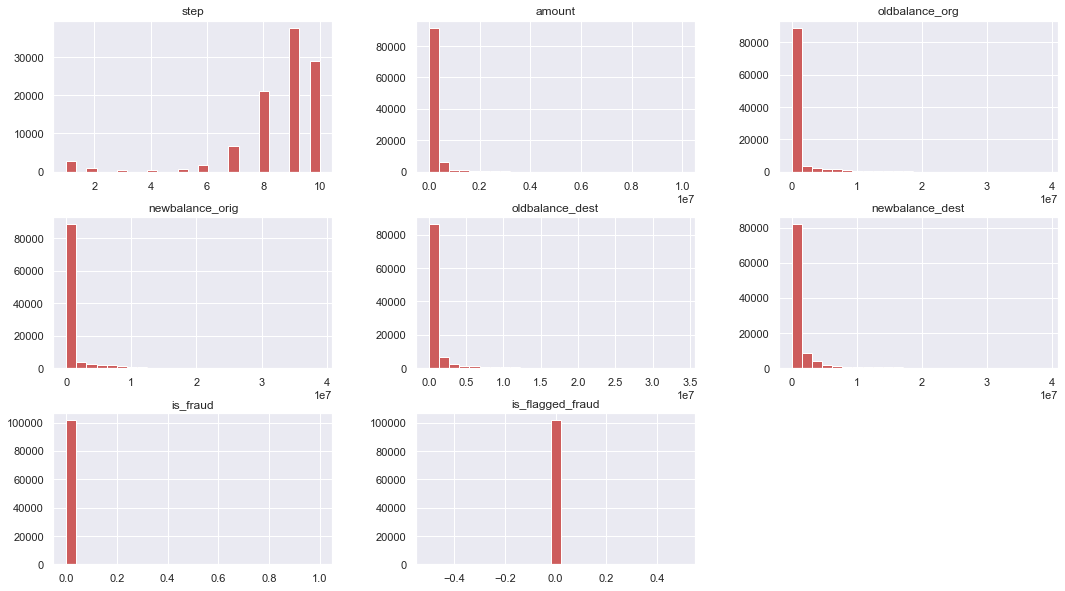

In [16]:
plt.figure(figsize = (30,60))
num_attributes.hist(bins= 25, color= 'indianred');

### 1.7.2 Atributos categóricos

In [17]:
cat_attributes.apply(lambda x: x.unique().shape[0])

type              5
name_orig    101613
name_dest     52280
dtype: int64

<AxesSubplot:xlabel='type', ylabel='count'>

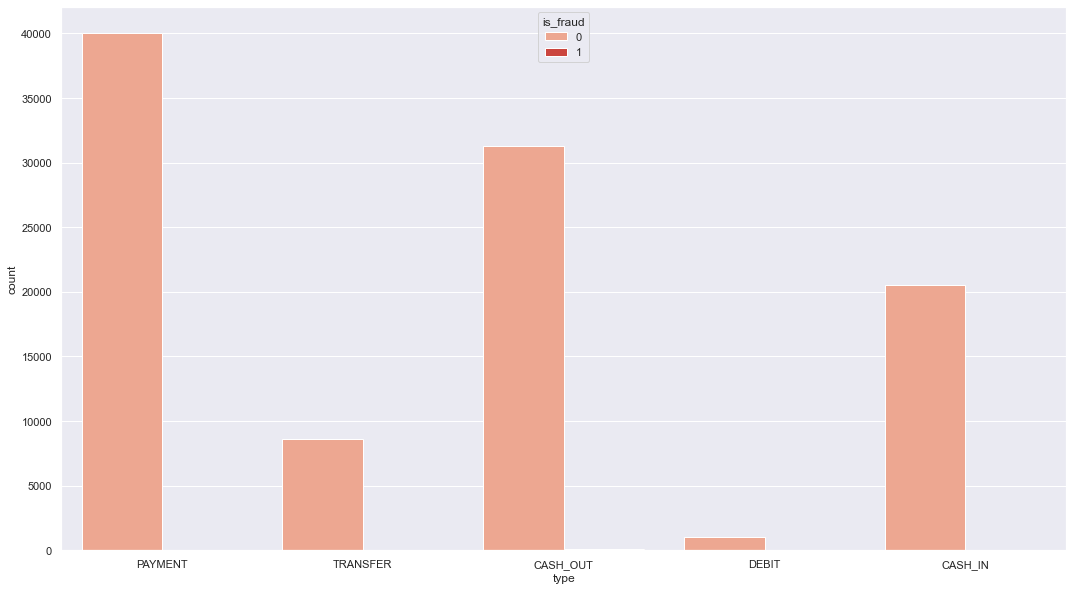

In [18]:
sns.countplot( x='type', hue='is_fraud', data=df1, palette = 'Reds')

### 1.7.3 Pandas profiling

In [20]:
pandas_profiling.ProfileReport(df1)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 2 Feature engineering

In [21]:
df2 = df1.copy()

## 2.1 Mapa Mental de hipóteses

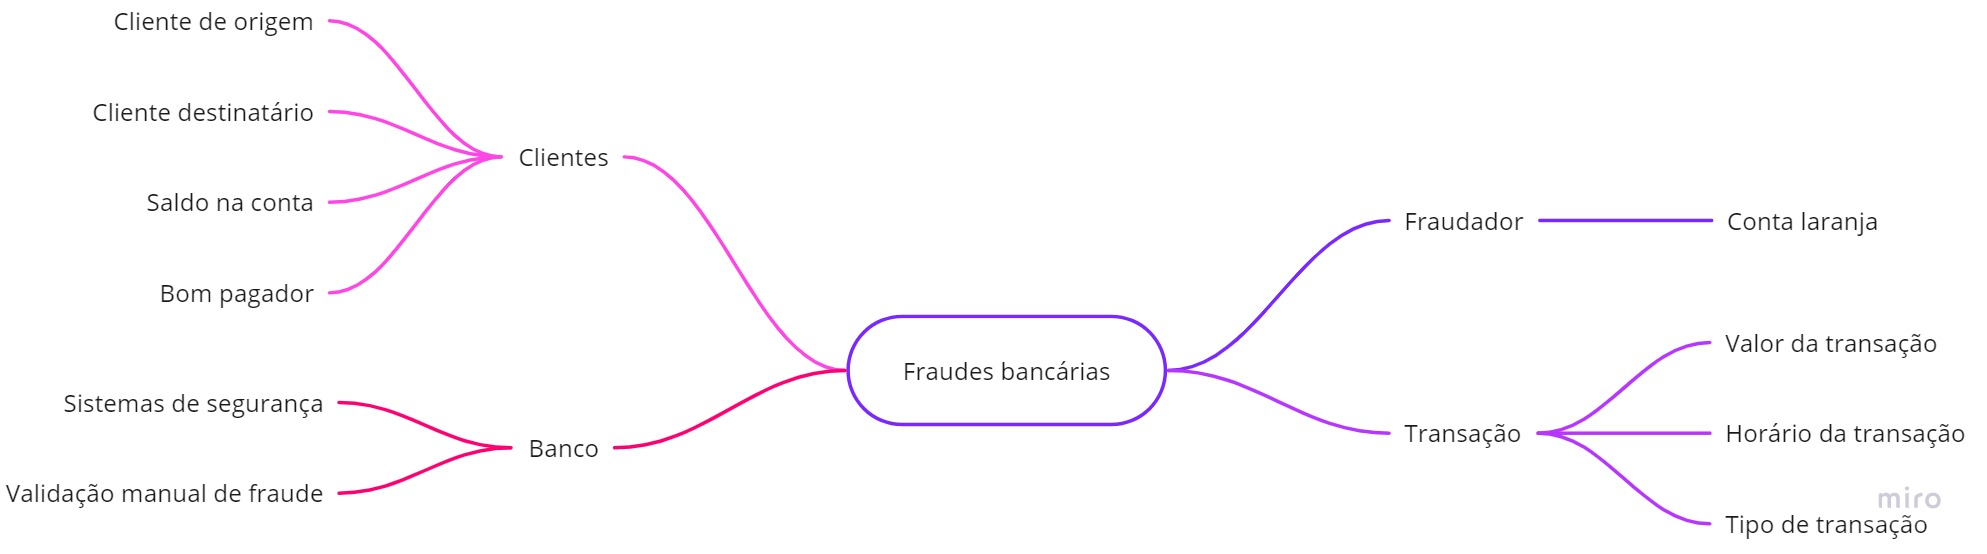

In [22]:
Image("../images/mind_map_fraud.jpg")

## 2.2 Criação das hipóteses

### 2.2.1 Hipóteses para Clientes

**1. Quanto maior o saldo na conta, maior a chance de sofrer uma fraude**

### 2.2.2 Hipóteses para Transação

**1. Quanto maior o valor da transação, maior a chance de ser fraude**

**2. Horário de transação entre step 0 - 7 acontecem mais fraudes**

**3. Tipo de transação TRANSFER E DEBIT acontecem mais fraude**

## 2.3 Lista final de hipóteses

**H1: Quanto maior o saldo na conta, maior a chance de sofrer uma fraude**

**H2: Quanto maior o valor da transação, maior a chance de ser fraude**

**H3: Horário de transação entre step 0 - 7 acontecem mais fraudes**

**H4: Tipo de transação TRANSFER E DEBIT acontecem mais fraude**

## 2.4 Criação de novas variáveis

In [24]:
#Null

In [25]:
df2.head().T

,0,1,2,3,4
step,1,1,1,1,1
type,PAYMENT,PAYMENT,TRANSFER,CASH_OUT,PAYMENT
amount,9839.64,1864.28,181.0,181.0,11668.14
name_orig,C1231006815,C1666544295,C1305486145,C840083671,C2048537720
oldbalance_org,170136.0,21249.0,181.0,181.0,41554.0
newbalance_orig,160296.36,19384.72,0.0,0.0,29885.86
name_dest,M1979787155,M2044282225,C553264065,C38997010,M1230701703
oldbalance_dest,0.0,0.0,0.0,21182.0,0.0
newbalance_dest,0.0,0.0,0.0,0.0,0.0
is_fraud,0,0,1,1,0


# 3 Filtragem dos dados

In [29]:
df3 = df2.copy()

## 3.1 Filtragem das colunas

In [30]:
#name_orig
df3 = df3.drop('name_orig', axis=1)

#name_dest
df3 = df3.drop('name_dest', axis=1)

#is_flagged_fraud
df3 = df3.drop('is_flagged_fraud', axis=1)

# 4. Análise exploratória de dados (EDA)

In [33]:
df4 = df3.copy()

In [34]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## 4.1 Análise univariada

### 4.1.1 Variável resposta

In [35]:
df4['is_fraud'].value_counts(normalize=True).reset_index().rename(columns={'index': 'is_fraud', 'response': 'pctg'})

,is_fraud,is_fraud
0,0,0.998858
1,1,0.001142


**Dados desbalanceados - aplicar alguma técnica de balanceamento de dados**

### 4.1.2 Variáveis numéricas

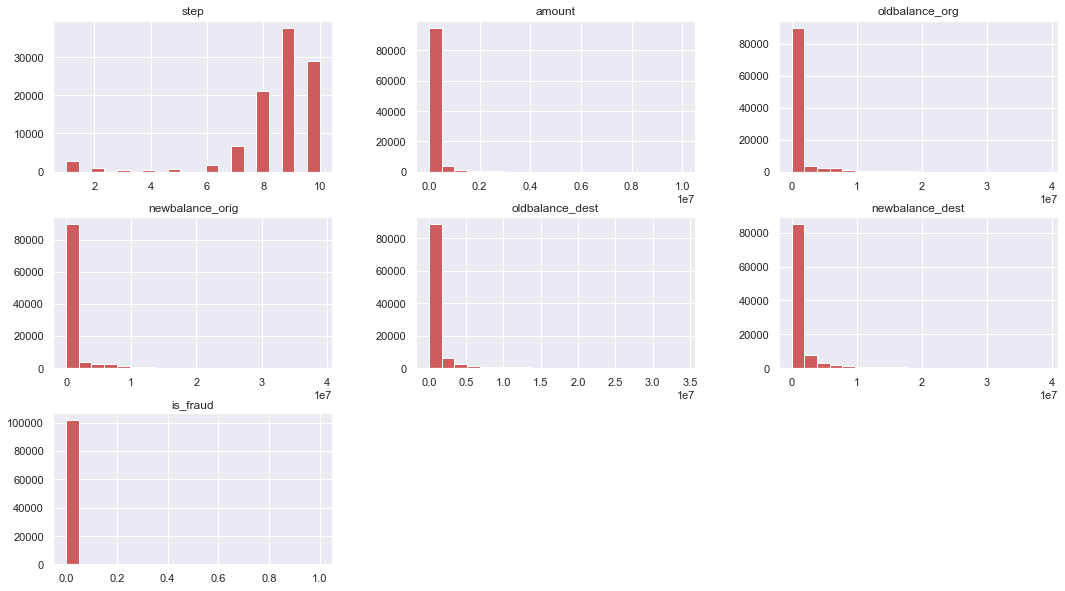

In [36]:
num_attributes.hist(color='indianred', bins=20);

**Nenhuma das variáveis segue a distribuição normal**

### 4.1.3 Variável categóricas

<AxesSubplot:xlabel='type', ylabel='count'>

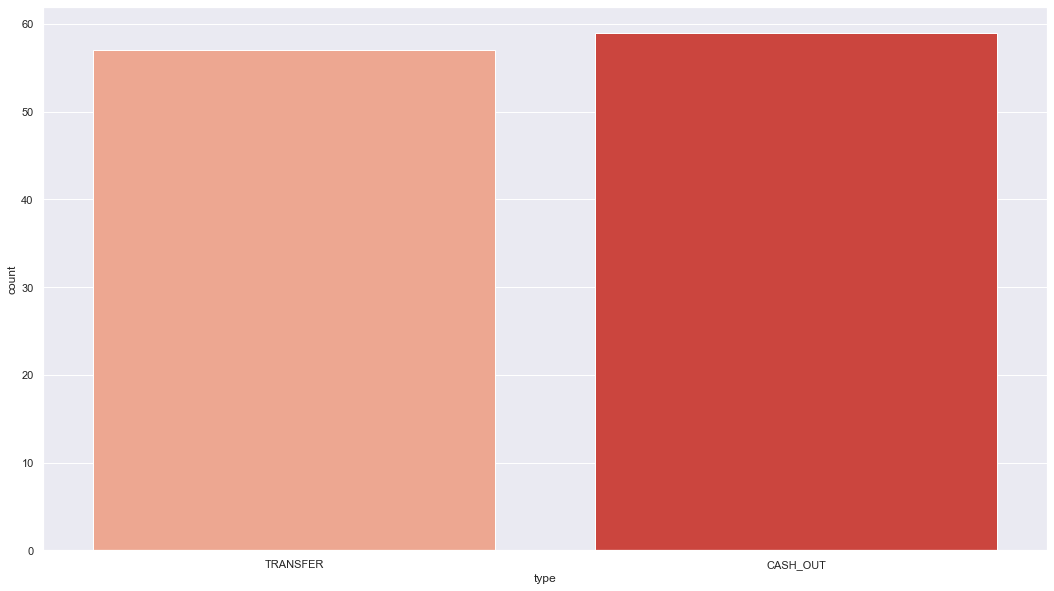

In [40]:
aux = df4[df4['is_fraud'] == 1]
sns.countplot(x='type', data=aux, palette = 'Reds')

## 4.2 Análise bivariada

In [49]:
df4.columns

Index(['step', 'type', 'amount', 'oldbalance_org', 'newbalance_orig',
       'oldbalance_dest', 'newbalance_dest', 'is_fraud'],
      dtype='object')

### **H1: Quanto maior o saldo na conta, maior a chance de sofrer uma fraude**
**VERDADEIRO** Visualmente, as fraudes acontecem mais em contas que tem o balanço na conta maior

<AxesSubplot:xlabel='is_fraud', ylabel='oldbalance_org'>

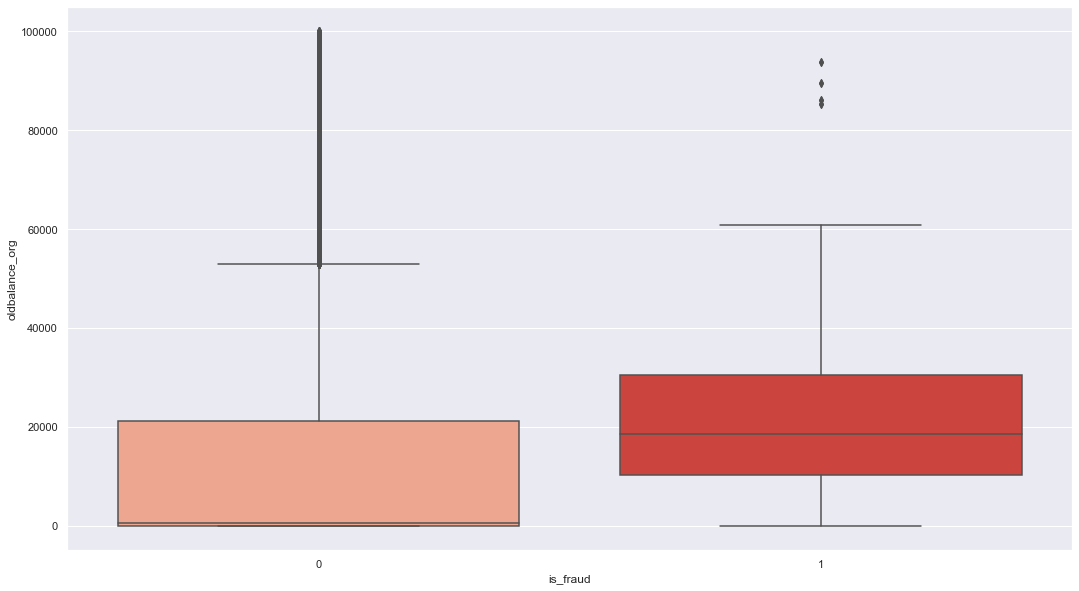

In [52]:
aux = df4[df4['oldbalance_org'] < 100000]
sns.boxplot( x=aux['is_fraud'], y=aux['oldbalance_org'], data=aux, palette = 'Reds')

<AxesSubplot:>

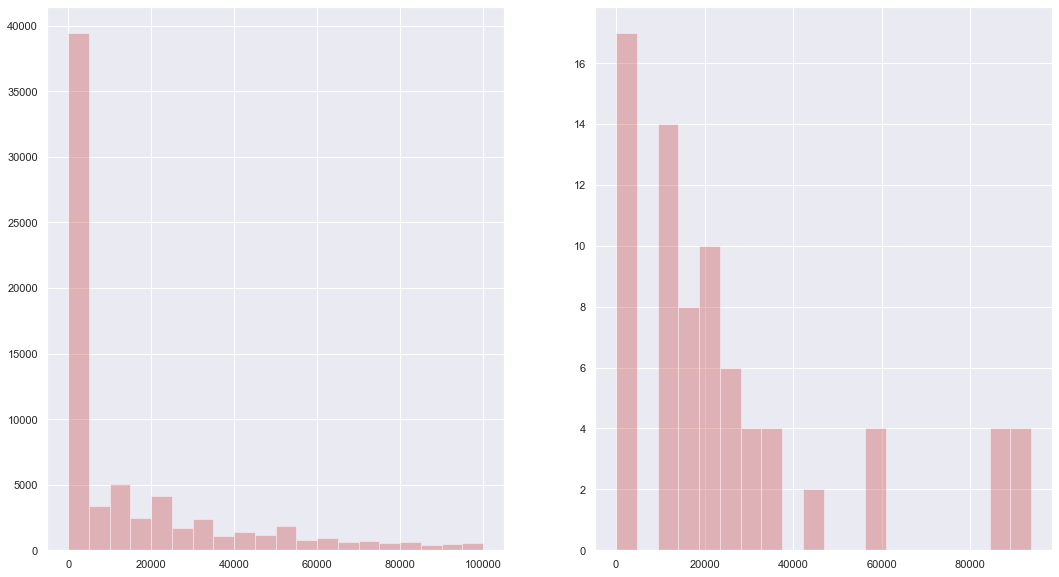

In [53]:
plt.subplot(1, 2, 1)
a1 = aux['oldbalance_org'][aux['is_fraud']==0]
sns.distplot( x=a1, kde=False, color='indianred', bins=20)

plt.subplot(1, 2, 2)
a2 = aux['oldbalance_org'][aux['is_fraud']==1]
sns.distplot( x=a2, kde=False, color='indianred', bins=20)

### **H2: Quanto maior o valor da transação, maior a chance de ser fraude**
**VERDADEIRA** Visualmente, fraudes tendem a acontecer com valores mais altos

<AxesSubplot:xlabel='is_fraud', ylabel='amount'>

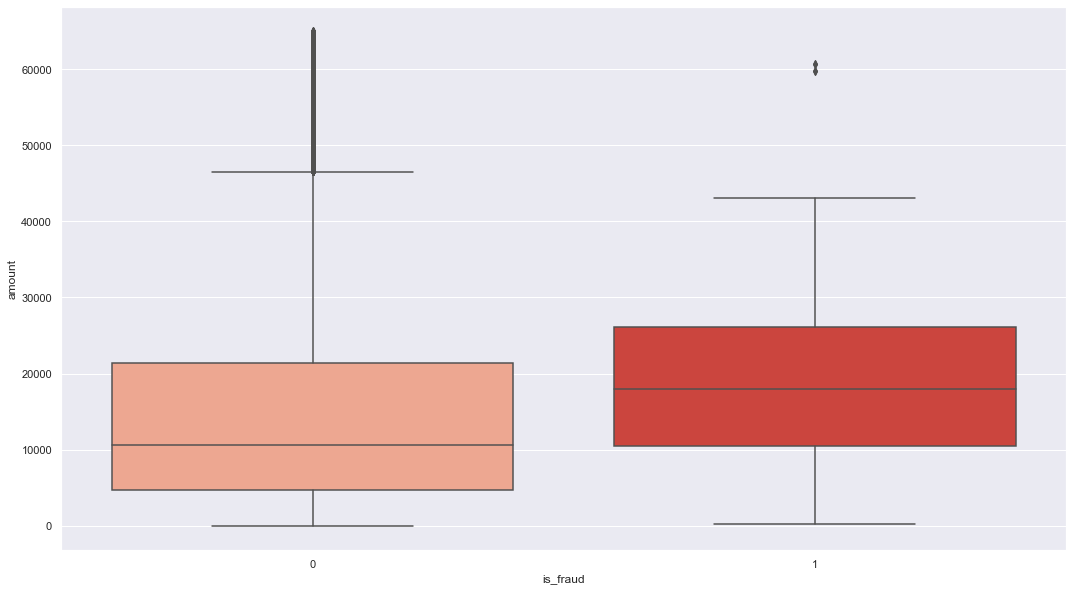

In [55]:
aux = df4[df4['amount'] < 65000]
sns.boxplot( x=aux['is_fraud'], y=aux['amount'], data=aux, palette = 'Reds')

<AxesSubplot:>

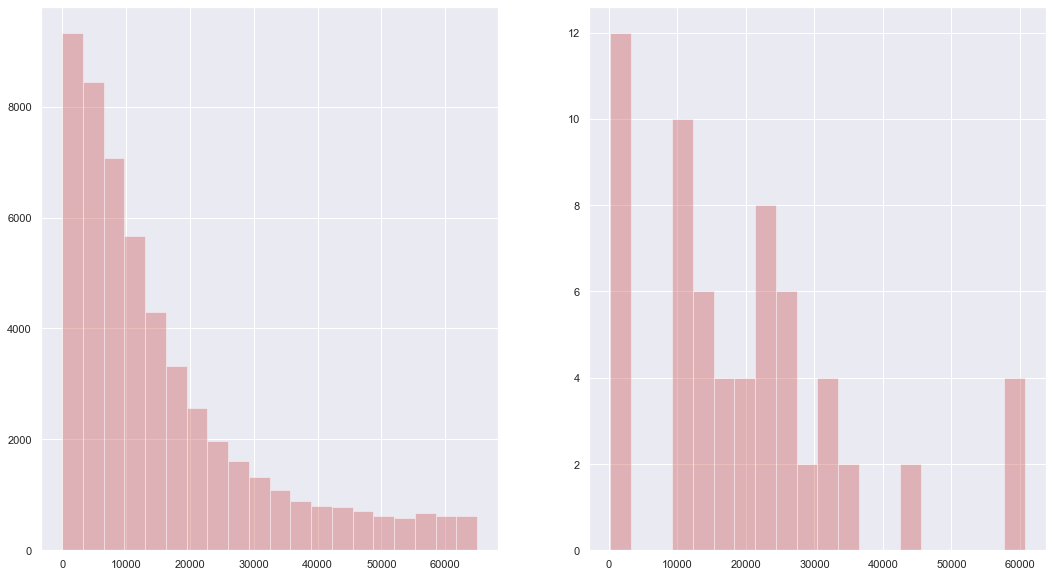

In [56]:
plt.subplot(1, 2, 1)
a1 = aux['amount'][aux['is_fraud']==0]
sns.distplot( x=a1, kde=False, color='indianred', bins=20)

plt.subplot(1, 2, 2)
a2 = aux['amount'][aux['is_fraud']==1]
sns.distplot( x=a2, kde=False, color='indianred', bins=20)

### **H3: Horário de transação entre step 0 - 7 acontecem mais fraudes**
**FALSA** Os steps 4 e 6 têm uma taxa de fraude maior

<AxesSubplot:>

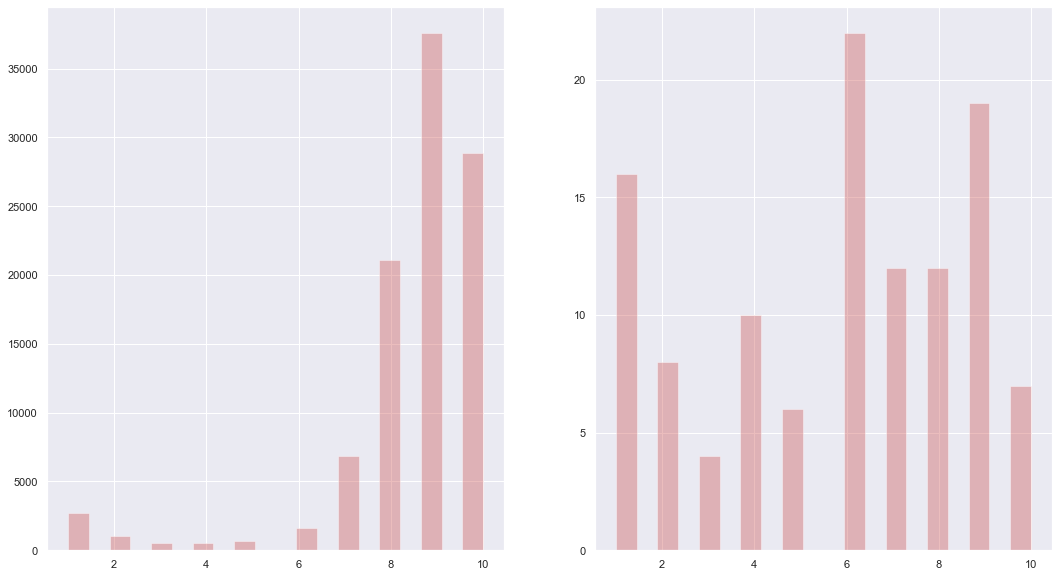

In [57]:
plt.subplot(1, 2, 1)
a1 = df4['step'][df4['is_fraud']==0]
sns.distplot( x=a1, kde=False, color='indianred', bins=20)

plt.subplot(1, 2, 2)
a2 = df4['step'][df4['is_fraud']==1]
sns.distplot( x=a2, kde=False, color='indianred', bins=20)

In [58]:
pd.crosstab(df4['step'], df4['is_fraud'], normalize='index')

is_fraud,0,1
step,,
1,0.994092,0.005908
2,0.992110,0.007890
3,0.992754,0.007246
4,0.982301,0.017699
5,0.990977,0.009023
6,0.986747,0.013253
7,0.998245,0.001755
8,0.999431,0.000569
9,0.999495,0.000505


### **H4: Tipo de transação TRANSFER E DEBIT acontecem mais fraude**
**FALSA** As fraudes se concentram nos tipos CASH_OUT E TRANSFER, sendo que TRANSFER tem uma taxa de fraude maior

In [60]:
pd.crosstab(df4['type'], df4['is_fraud'], normalize='index')

is_fraud,0,1
type,,
CASH_IN,1.000000,0.000000
CASH_OUT,0.998116,0.001884
DEBIT,1.000000,0.000000
PAYMENT,1.000000,0.000000
TRANSFER,0.993440,0.006560


In [61]:
pd.crosstab(df4['type'], df4['is_fraud'], normalize='columns')

is_fraud,0,1
type,,
CASH_IN,0.202371,0.000000
CASH_OUT,0.307901,0.508621
DEBIT,0.009971,0.000000
PAYMENT,0.394711,0.000000
TRANSFER,0.085047,0.491379


### 4.2.1 Resumo das hipóteses

In [70]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'VERDADEIRA', 'MÉDIA'],  
      ['H2', 'VERDADEIRA', 'BAIXA'],  
      ['H3', 'FALSA', 'MÉDIA'],
      ['H4', 'FALSA', 'ALTA'],
     ]  
print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           VERDADEIRA   MÉDIA
H2           VERDADEIRA   BAIXA
H3           FALSA        MÉDIA
H4           FALSA        ALTA


# 5 Preparação dos dados

In [81]:
df5 = df4.copy()

## 5.1 Normalização

## 5.2 Rescaling

In [82]:
rs = RobustScaler()

# amount
df5['amount'] = rs.fit_transform(df5[['amount']].values)

# oldbalance_org
df5['oldbalance_org'] = rs.fit_transform(df5[['oldbalance_org']].values)

# newbalance_orig
df5['newbalance_orig'] = rs.fit_transform(df5[['newbalance_orig']].values)

# oldbalance_dest
df5['oldbalance_dest'] = rs.fit_transform(df5[['oldbalance_dest']].values)

# newbalance_dest
df5['newbalance_dest'] = rs.fit_transform(df5[['newbalance_dest']].values)

## 5.3 Transformação

### 5.3.1 Encoding

In [83]:
# type - One Hot Encoder
df5 = pd.get_dummies(df5, prefix='type', columns=['type'])

### 5.3.2 Transformação de natureza

In [84]:
# step
df5['step_sin'] = df5['step'].apply(lambda x: np.sin(x * (2. * np.pi/10)))
df5['step_cos'] = df5['step'].apply(lambda x: np.cos(x * (2. * np.pi/10)))

## 5.4 Balanceamento dos dados

In [88]:
# calling method
SEED=42
smote = SMOTE(random_state=SEED)

# df in x e y
X = df5.drop('is_fraud', axis=1)
y = df5['is_fraud']

# fit data
x_resampled, y_resampled = smote.fit_resample(X, y)

df5 = pd.concat([y_resampled, x_resampled], axis=1)
df5['is_fraud'].value_counts()

0    101497
1    101497
Name: is_fraud, dtype: int64

# 6 Seleção de variáveis

In [ ]:
df6 = df5.copy()

## 6.1 Separação do conjunto de dados em treino e teste

## 6.2 Feature selector

## 6.3 Seleção de variáveis manual após feature selector

# 7 Machine learning

## 7.1 Modelo-n

## 7.6 Comparando a perfomance dos modelos

### 7.6.1 Performance única fold

### 7.6.2 Performance cross validation

# 8 Otimizando dos hiperparâmetros

## 8.1 Método otimizador

## 8.2 Modelo final tunado

Tempo de execução: 1h09

# 9 Interpretação e tradução do erro

## 9.1 Performance do negócio

# 10 Deployment do modelo em produção

In [ ]:
# Save Trained Model


## 10.1 Model class

## 10.2 API handler

## 10.3 API tester